# Amazon Product Recommender

**Jason Truong**  **|**  Jasontruong19@gmail.com  **|**  September 25, 2022

**Problem Statement:** based on a person’s review of a product, can items of similar properties be recommended to them such that they are more inclined to buy the item? This project adds business value by improving the customer buying experience on Amazon through personalized recommendations for products. These recommendations influence customer purchases by making it easier for customers to find similar products. 

***

# 2 Modelling without Text Data

**Note**: This is notebook **3 of 5** for building the recommendation system.

# Table of Contents

1. **[Introduction](#1Introduction)**  
2. **[Preliminary Data Setup](#2Preliminary)**  
    2.1. [Set up Train/Test Split](#2.1traintest)  
    2.2. [Scale data](#2.2scaledata)  
3. **[Logistic Regression](#3logistic)**  
    3.1 [Logistic model](#3.1logitmodel)  
    3.2 [Logistic Hyperparameter tuning](#3.2logit_tuning)  
4. **[Decision Tree](#4decisiontree)**  
    4.1 [Decision Tree model](#4.1dtmodel)  
    4.2 [Decision Tree Hyperparameter tuning](#4.2dt_tuning)  
5. **[XGBoost](#5xgboost)**  
    5.1 [XGBoost model](#5.1xgboost_model)  
6. **[Summary](#6summary)**


# 1. Introduction<a class ='anchor' id='1Introduction'></a>

With the preprocessed data from the first notebook, (Preprocessing and EDA) the data can now be used in different models. This notebook uses two classification models, logistic regression, a decision tree model as well as an ensemble method, XGBoost to model the preprocessed data. The objective is to determine how well the models will perform using only the numeric features (excluding the text portion of the review) to predict the the sentiment of the review.

# 2. Preliminary Data Setup<a class ='anchor' id='2Preliminary'></a>

The necessary base packages will be imported below.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The review dataset will be loaded in.

In [2]:
review_df = pd.read_json('numeric_review.json')

# Check the data that is loaded in
review_df.head()

,reviewScore,verified,vote,reviewDay,reviewMonth,reviewYear,style_Amazon Video,style_Blu-ray,style_DVD,style_Other,style_VHS Tape,reviewer_ID,itemID
0,5,1,4,2,11,2002,0,0,1,0,0,0,0
1,5,0,3,28,1,2002,0,0,1,0,0,1,0
2,5,0,2,12,12,2001,0,0,1,0,0,2,0
3,3,0,31,11,12,2001,0,0,0,0,1,3,0
4,4,0,62,19,10,2001,0,0,1,0,0,4,0


The review score will be split into positive (value of 1) and negative (value of 0) for sentiment analysis. Anything below 4 will be mapped to 0 and anything above and including 4 will be mapped to 1.

In [3]:
# Map review score values 
review_df['reviewClass'] = np.where(review_df['reviewScore']>=4,1,0)

# Check results
review_df['reviewClass'].value_counts()

1    1418290
0     279963
Name: reviewClass, dtype: int64

The `reviewClass` column now only has two classes. The proportion of positive and negative reviews can be determined.

In [4]:
(review_df['reviewClass'].value_counts()/review_df.shape[0])*100

1    83.514647
0    16.485353
Name: reviewClass, dtype: float64

83.5% of the reviews have a positive sentiment. Now that the reviews have been split into positive and negative sentiments, a train/test split can be made. The baseline accuracy will be taken as 83.5% since this is the score if the prediction for the reviews is all taken to be positive.

## 2.1 Setup train and test split<a class ='anchor' id='2.1traintest'></a>

In [5]:
from sklearn.model_selection import train_test_split

# The prediction is for the reviewScore
X = review_df.drop(columns = ['reviewScore','reviewClass'])
y = review_df['reviewClass']

# Create the train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify = y)

**Note: A validation set is not made because the hyperparameter tuning will be done in a pipeline with a 5-fold cross validation. Thus, a validation set is not needed.**

## 2.2 Scale the data<a class ='anchor' id='2.2scaledata'></a>

Since many of the columns are on different scales, a standard scaler will be used to normalize the data.

In [6]:
from sklearn.preprocessing import StandardScaler

# Instantiate Scaler
ss = StandardScaler()

# Fit the Scaler
ss.fit(X_train)

# Transform
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [7]:
# Check the transformed values
X_train_ss

array([[ 0.68897563, -0.11846769, -1.10148481, ..., -0.20102521,
        -1.05267921, -1.37937145],
       [ 0.68897563, -0.11846769, -0.4245678 , ..., -0.20102521,
        -0.9768615 , -0.27774056],
       [-1.45143014, -0.11846769,  1.26772472, ..., -0.20102521,
        -1.23518041, -0.4683722 ],
       ...,
       [-1.45143014, -0.11846769,  0.59080771, ..., -0.20102521,
        -1.25759007,  0.80006137],
       [ 0.68897563, -0.11846769,  0.36516871, ..., -0.20102521,
        -0.61839854, -1.1456644 ],
       [ 0.68897563, -0.11846769,  1.60618322, ..., -0.20102521,
         1.42761554,  0.99802499]])

The data in both the training and test set has been normalized so now they can be used in the different models.

# 3. Logistic Regression<a class ='anchor' id='3logistic'></a>

A simple logisitic regression will be used to start things off and see how well the model fits the data.

## 3.1 Logistic Model<a class ='anchor' id='3.1logitmodel'></a>

In [8]:
from sklearn.linear_model import LogisticRegression

# Instantiate
logreg = LogisticRegression(C = 1)

# Fit the model
logreg.fit(X_train_ss,y_train)

# Score the model
print(f"Train score: {logreg.score(X_train_ss,y_train)}")
print(f"Test score: {logreg.score(X_test_ss,y_test)}")

Train score: 0.8349565710310759
Test score: 0.8349977859639536


The train and test scores are very close to one another which shows that the model may be performing well. Since the review dataset had 83.5% positive reviews, the logistic regression model is not performing better than randomly guessing everything as positive. The coefficients of the model can be explored to see how they impact the sentiment.

In [9]:
# Determine the model coefficients
logreg.coef_[0]

array([ 0.24753507, -0.05912898, -0.00662655,  0.00892323,  0.1743462 ,
       -0.17540836,  0.00087482,  0.0147989 , -0.00355748,  0.04538284,
        0.07188777, -0.09134039])

In [10]:
# Show which column the coefficient is referring to.
X_train.columns

Index(['verified', 'vote', 'reviewDay', 'reviewMonth', 'reviewYear',
       'style_Amazon Video', 'style_Blu-ray', 'style_DVD', 'style_Other',
       'style_VHS Tape', 'reviewer_ID', 'itemID'],
      dtype='object')

In [11]:
# Make coefficient dataframe
coeff_df = pd.DataFrame({"coefficients": logreg.coef_[0]}, index = X_train.columns).sort_values('coefficients', ascending = True)

# Check results
coeff_df

,coefficients
style_Amazon Video,-0.175408
itemID,-0.091340
vote,-0.059129
reviewDay,-0.006627
style_Other,-0.003557
style_Blu-ray,0.000875
reviewMonth,0.008923
style_DVD,0.014799
style_VHS Tape,0.045383
reviewer_ID,0.071888


The coefficients are relatively small for all the features with the highest coefficient being 0.25 for `verified` and the lowest coefficient being -0.17 for `style_Amazon Video` A plot can be made to better visualize the coefficients.

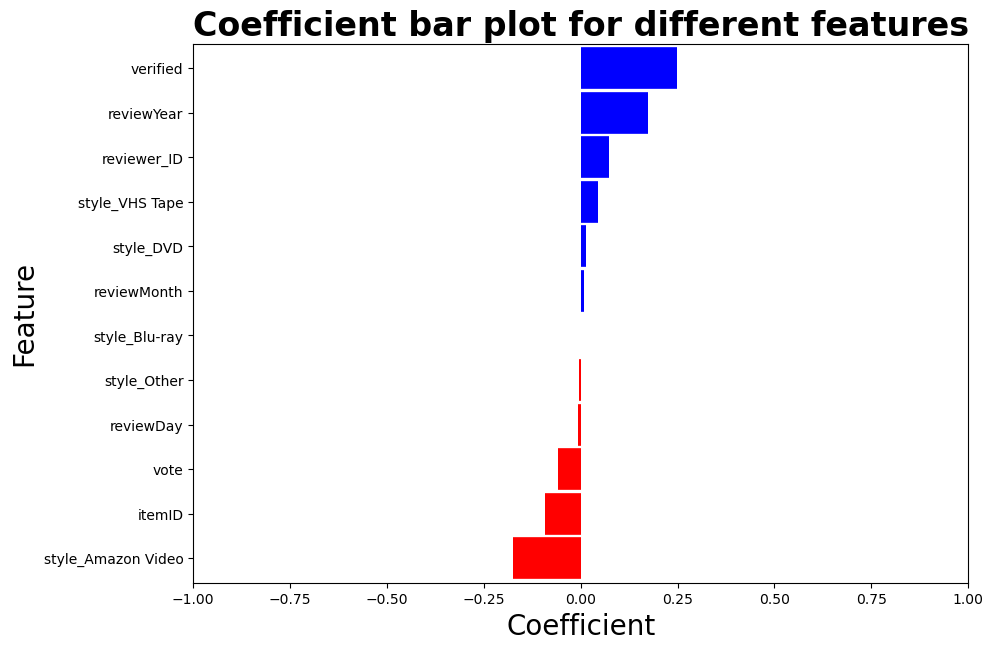

In [12]:
# Set up figure size
plt.figure(figsize = (10,7))

# Plot the coefficients 
plt.hlines(y = coeff_df.index, 
           xmax = coeff_df['coefficients'], 
           xmin = 0, 
           linewidth = 30,
           color = ['r' if c<0 else 'b' for c in coeff_df['coefficients']])

# Set x axis range
plt.xlim([-1,1])

# Label the plot
plt.title(f'Coefficient bar plot for different features', fontweight = 'bold', fontsize = 24)
plt.xlabel('Coefficient', fontsize = 20)
plt.ylabel('Feature', fontsize = 20)

plt.show()

By looking at the plot above, the conclusion that can be drawns that the data without text features is not highly correlated with the sentiment of the review.

The above model can be saved so that this notebook can be run without fitting the model again.

In [13]:
# Save the above model
pickle.dump(logreg, open('Saved_Models/2_log_reg_model.pickle','wb'))

In [14]:
# Load the saved model
# logreg = pickle.load(open('Saved_Models/2_log_reg_model.pickle','rb'))

To further analyze these results, the precision and recall scores can be reviewed for the logistic model.

In [15]:
from sklearn.metrics import classification_report

# Get the model predictions.
y_pred = logreg.predict(X_test_ss)

# Get the classification report for the model
c_report_logreg = classification_report(y_test,y_pred)

print(c_report_logreg)

              precision    recall  f1-score   support

           0       0.22      0.00      0.00     69991
           1       0.84      1.00      0.91    354573

    accuracy                           0.83    424564
   macro avg       0.53      0.50      0.46    424564
weighted avg       0.73      0.83      0.76    424564



The precision and recall for predicting positive reviews are great but the recall and precision for predicting negative reviews are terrible. This can be due to the imbalanced dataset and how the features do not have much predictive power for predicting the sentiment. A confusion matrix can be plotted to see how many reviews were predicted correctly.

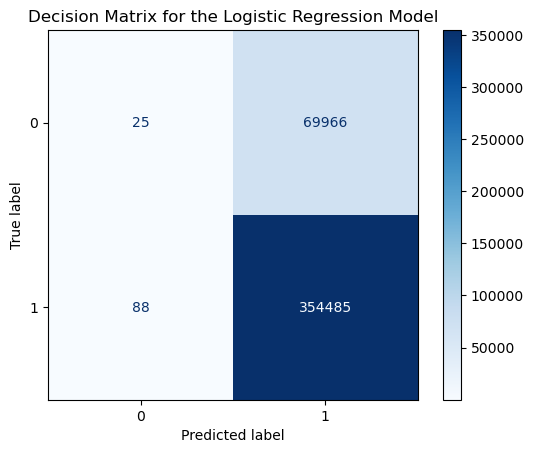

In [16]:
from sklearn.metrics import plot_confusion_matrix

# Plot the decision matrix
plot_confusion_matrix(logreg, X_test_ss, y_test, cmap = 'Blues', values_format ='')

# Add labels to the plot
plt.title('Decision Matrix for the Logistic Regression Model')
plt.show()

The above decision matrix shows that the model is unable to generalize the data well for negative reviews. Only 21 out of 69991 negative reviews were predicted correctly. The recall and precision are better evaluation metrics for this dataset because of the unbalanced dataset.

Since the classification report and confusion matrix will be used to evaluate the other models, functions will be created to reduce the code redundency in this and other notebooks.

**Create a function to run the classification report and confusion matrix**

In [17]:
def class_report(model,X_test_ss,y_test):
    '''
    This function takes in the machine learning model as well as the test data and outputs a classification report.
    
    '''
    
    # Get the model predictions.
    y_pred = model.predict(X_test_ss)

    # Get the classification report for the model
    c_report = classification_report(y_test,y_pred)
    
    return print(c_report)

In [18]:
def conf_matrix(model,X_test_ss,y_test,model_type):
    '''
    This function takes in the machine learning model, test data and the model name. 
    The output is a decision matrix for the model
    
    '''
    
    # Plot the decision matrix
    plot_confusion_matrix(model, X_test_ss, y_test, cmap = 'Blues', values_format ='')

    # Add labels to the plot
    plt.title(f'Decision Matrix for the {model_type} model')
    plt.show()

Now that there is a function to output the classification report and decision matrix, it will be used in this notebook for the other models.

## 3.2 Logistic Hyperparameter Tuning <a class ='anchor' id='3.2logit_tuning'></a>

**Create a ML Pipelines to determine the best hyper parameters** 

Machine learning pipelines are a useful tool to help test multiple parameters at once and they also help ensure that there is no data leakage to the test set. 

In [19]:
# Set up caching for the pipeline.
from tempfile import mkdtemp
cachedir = mkdtemp()

First, the pipeline structure will be set up.

In [20]:
from sklearn.pipeline import Pipeline

# Instantiate pipeline settings
estimators = [('normalize', StandardScaler()),
             ('model', LogisticRegression())]

# Instantiate pipeline model
pipeline_model = Pipeline(estimators, memory = cachedir)

The pipeline will include different parameters for the logistic regression as well as a scaling function to determine if scaling makes a difference in the model performance. 

In [21]:
from sklearn.model_selection import GridSearchCV

# Set up parameters for the pipeline
logit_param_grid = [
    
    {'normalize': [None, StandardScaler()],
     'model__solver': ['lbfgs', 'liblinear'],
     'model__penalty': ['l2'],
     'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
]

# Instantiate grid search
logit_gsearch = GridSearchCV(estimator=pipeline_model, param_grid=logit_param_grid, cv = 5, verbose = 1, n_jobs = -1)

Now that the model is created, we can fit the grid search with a 5 fold cross validation.

In [22]:
fit_logit_grid = logit_gsearch.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [23]:
fit_logit_grid.best_params_

{'model__C': 0.0001,
 'model__penalty': 'l2',
 'model__solver': 'lbfgs',
 'normalize': None}

The best model with the different parameters are shown above.

In [24]:
# Score the model
print(f"Train score: {logit_gsearch.score(X_train,y_train)}")
print(f"Test score: {logit_gsearch.score(X_test,y_test)}")


Train score: 0.8351465703166158
Test score: 0.8351461734862118


The best logistic regression model did not improve the train or test score.

The above model can be saved so this notebook can be run without fitting the model again.

In [25]:
# Save the above model
pickle.dump(logit_gsearch, open('Saved_Models/2_logit_optimized_model.pickle','wb'))

In [26]:
# Load the saved model
# logit_gsearch = pickle.load(open('Saved_Models/2_logit_optimized_model.pickle','rb'))

The classification report and decision matrix can be created to see if the hyperparameter tuning affected the original logistic regression results.

In [27]:
# Determine the precision and recall of the model
class_report(logit_gsearch,X_test_ss,y_test)

              precision    recall  f1-score   support

           0       0.22      0.41      0.29     69991
           1       0.86      0.72      0.78    354573

    accuracy                           0.66    424564
   macro avg       0.54      0.56      0.53    424564
weighted avg       0.75      0.66      0.70    424564



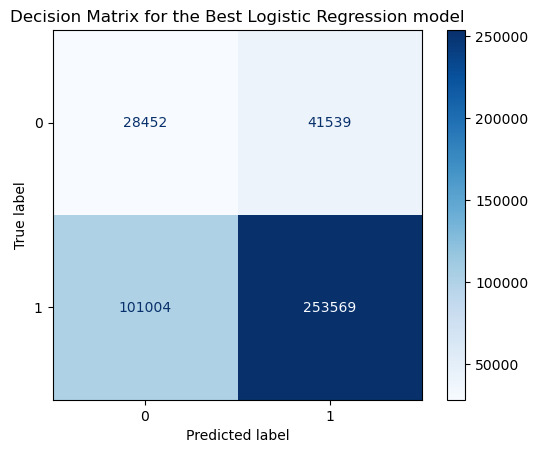

In [28]:
# Plot the decision matrix
conf_matrix(logit_gsearch,X_test_ss,y_test, 'Best Logistic Regression')

The tuned logistic regression model is able to predict negative reviews better as the recall for negative predictions increased significantly from 0 to 40%. Although the model can better predict negative reviews, the recall for the positive predictions dropped from 100% to 71%. This hyperparameter tuning made the model predict more negative reviews which is a good step toward predicting negative sentiment better. The downside is that the model predicts fewer positive reviews.

# 4. Decision Tree<a class ='anchor' id='4decisiontree'></a>

The decision tree model can also be used to fit the data to determine if the numeric features without the text data affect the sentiment prediction. A decision tree model will be used because they fit non-linear relationships well and this dataset contains non-linear relationships.

## 4.1 Decision Tree Model<a class ='anchor' id='4.1dtmodel'></a>

A simple decision tree model will be fit to the data.

In [29]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate
decisiontree_model = DecisionTreeClassifier()

# Fit the model
decisiontree_model.fit(X_train_ss,y_train)

# Score the model
print(f"Train score: {decisiontree_model.score(X_train_ss,y_train)}")
print(f"Test score: {decisiontree_model.score(X_test_ss,y_test)}")

Train score: 0.9999466117710053
Test score: 0.7626129393919409


The training score is almost at 1, thus the model is overfitting. This is expected because the max depth wasn't specified in the model so the tree expanded to as many leaves as possible. The test score is lower than the baseline so the current model performs worst than if we guessed that all the reviews were positive.

The above model can be saved so this notebook can be run without fitting the model again.

In [30]:
# Save the above model
pickle.dump(decisiontree_model, open('Saved_Models/2_dt_model.pickle','wb'))

In [31]:
# Load the saved model
#decisiontree_model = pickle.load(open('Saved_Models/2_dt_model.pickle','rb'))

To further analyze these results, the precision and recall scores can be determined for the decision tree model.

In [32]:
# Determine the precision and recall of the model

class_report(decisiontree_model,X_test_ss,y_test)

              precision    recall  f1-score   support

           0       0.29      0.31      0.30     69991
           1       0.86      0.85      0.86    354573

    accuracy                           0.76    424564
   macro avg       0.58      0.58      0.58    424564
weighted avg       0.77      0.76      0.77    424564



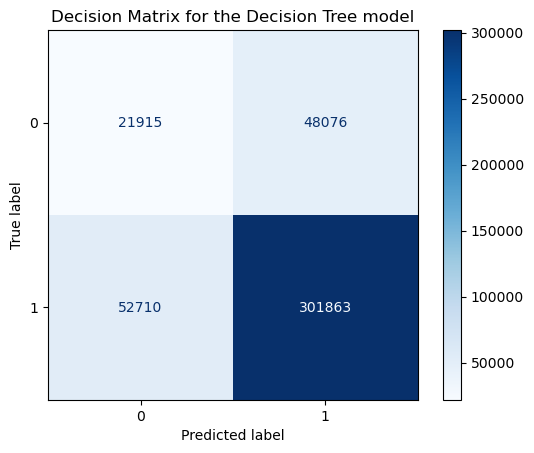

In [33]:
# Plot the decision matrix
conf_matrix(decisiontree_model,X_test_ss,y_test, 'Decision Tree')

Although the decision tree accuracy score is lower than the logistic regression accuracy score. The precision and recall are better for predicting the negative sentiment which makes this model better overall.

## 4.2 Decision Tree Hyperparameter Tuning<a class ='anchor' id='4.2dt_tuning'></a>

First, the pipeline structure will be set up.

In [34]:
# Instantiate pipeline settings
tree_estimators = [('model', DecisionTreeClassifier())]

# Instantiate pipeline model
tree_pipeline_model = Pipeline(tree_estimators, memory = cachedir)

In [35]:
# Set up parameters for the pipeline
tree_param_grid = [
    
    {'model__max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
     'model__min_samples_leaf': [2, 4, 6, 8, 10]}
]

# Instantiate grid search
tree_gsearch = GridSearchCV(estimator=tree_pipeline_model, param_grid=tree_param_grid, cv = 5, verbose = 1, n_jobs = -1)

Fit the grid search with a 5 fold cross validation.

In [36]:
fit_tree_grid = tree_gsearch.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [37]:
# Determine the best decision tree hyper parameters
fit_tree_grid.best_params_

{'model__max_depth': 10, 'model__min_samples_leaf': 2}

In [38]:
print(f'Decision Tree model train set accuracy: {round(tree_gsearch.score(X_train,y_train),4)}%')
print(f'Decision Tree model train set accuracy: {round(tree_gsearch.score(X_test,y_test),4)}%')

Decision Tree model train set accuracy: 0.8387%
Decision Tree model train set accuracy: 0.8372%


The best parameters for the decision tree did not increase the baseline accuracies by a significant amount.

In [39]:
# Save the above model
pickle.dump(fit_tree_grid, open('Saved_Models/2_dt_optimized_model.pickle','wb'))

In [40]:
# Load the saved model
# fit_tree_grid = pickle.load(open('Saved_Models/2_dt_optimized_model.pickle','rb'))

The classification report and decision matrix can be created to see if the hyperparameter tuning affected the original logistic regression results.

In [41]:
# Determine the precision and recall of the model

class_report(fit_tree_grid,X_test,y_test)

              precision    recall  f1-score   support

           0       0.56      0.06      0.10     69991
           1       0.84      0.99      0.91    354573

    accuracy                           0.84    424564
   macro avg       0.70      0.52      0.51    424564
weighted avg       0.80      0.84      0.78    424564



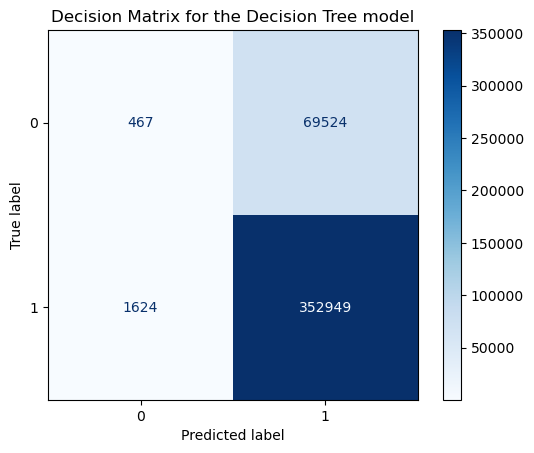

In [42]:
# Plot the decision matrix
conf_matrix(fit_tree_grid,X_test_ss,y_test, 'Decision Tree')

Although the accuracy of the new tree model increased, the precision and recall for the best decision tree model are performing just as poorly as the logistic regression model. This is most likely due to the numeric features not having any predictive power towards the sentiment prediction. 

# 5. XGBoost<a class ='anchor' id='5xgboost'></a>

An ensemble method can be experimented with to determine if the data can be fitted well. This section will use XGBoost to fit the model because XGboost is effective in fitting large scale datasets.

## 5.1 XGboost Model<a class ='anchor' id='5.1xgboost_model'></a>

The XGboost model with no hyper parameter tuning will be ran below to fit the data.

In [43]:
from xgboost import XGBClassifier

# Instantiate model
XGB_model = XGBClassifier()

# Fit model
XGB_model.fit(X_train_ss,y_train)

# Score the model
print(f"Train score: {XGB_model.score(X_train_ss,y_train)}")
print(f"Test score: {XGB_model.score(X_test_ss,y_test)}")

Train score: 0.8427190625026989
Test score: 0.8410863850915292


The train and test scores are very slightly better than the baseline accuracy of 0.835. The XGBoost model is the best model to predict the sentiment of the reviews when the model can only train on the review numeric features.

The above model can be saved so this notebook can be run without fitting the model again.

In [44]:
# Save the above model
pickle.dump(XGB_model, open('Saved_Models/2_xgb_model.pickle','wb'))

In [45]:
# Load the saved model
# XGB_model = pickle.load(open('Saved_Models/2_xgb_model.pickle','rb'))

To further analyze these results, the precision and recall scores can be determined for the XGBoost model.

In [46]:
# Determine the precision and recall of the model
class_report(XGB_model,X_test_ss,y_test)

              precision    recall  f1-score   support

           0       0.66      0.07      0.13     69991
           1       0.84      0.99      0.91    354573

    accuracy                           0.84    424564
   macro avg       0.75      0.53      0.52    424564
weighted avg       0.81      0.84      0.78    424564



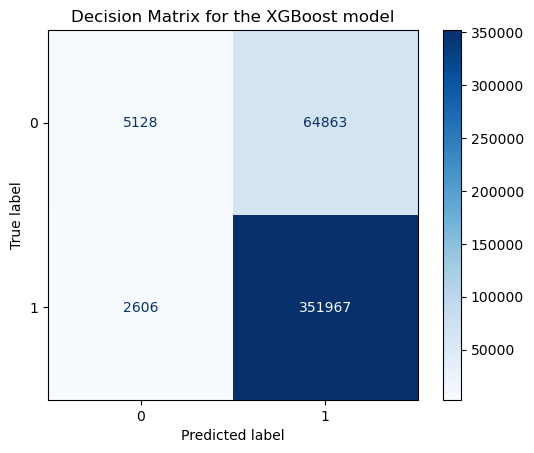

In [47]:
# Plot the decision matrix
conf_matrix(XGB_model,X_test_ss,y_test, 'XGBoost')

From the decision matrix and classification report above, the XGBoost model performs well in predicting positive reviews. The precision for negative reviews is decent but the recall is not great as the model is predicting positive reviews too often. This is a result of the unbalanced dataset and the model generalizing more to the positive reviews.

**Due to time constraints, the XGBoost hyperparameter tuning will not be analyzed for now and will be future work.**

# 6. Summary<a class ='anchor' id='6summary'></a>

None of the models are able to predict the sentiment well without the text data. Since the data is highly unbalanced, the models are unable to predict the negative reviews effectively. 